# Evaluation
**Table of content**

* [Prepare functions](#prepare_functions)
* [Tune models](#tuning)
    * [Save best parametes](#save_best)
* [Retrain models on best parameters](#retrain)
* [Find top features](#top_features)
    * [RFC](#rfc_top)
    * [LR](#lr_top)
    * [MLP](#mlp_top)

In [1]:
import datetime
import numpy as np
import pandas as pd
from joblib import parallel_backend
from typing import Dict, List, Union
from tqdm import tqdm
import os
import pathlib
import scipy
import itertools
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pickle

from utils.metrics_evaluation import display_metrics

param_grid_LR = {"C": [0.1, 1, 100], "penalty": ['l1', 'l2'],
                "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
                "multi_class": ["ovr"],
                "n_jobs": [4],
                "max_iter": [10]}
param_grid_RFC = {'n_estimators': [2, 5, 10],"criterion": ["gini", "entropy", "log_loss"],"max_features": ["sqrt", "log2"]}

param_grid_MLP = {"activation": ["identity", "logistic", "tanh", "relu"], "solver": ['sgd', 'adam'], "alpha": [0.0001, 0.001, 0.05, 0.1], 
"max_iter": [5, 10]}

data_path = '/home/vlad/Документы/sparse.npz'
y_path = '/home/vlad/Документы/y.csv'

df_all_data = scipy.sparse.load_npz(data_path)
y = pd.read_csv(y_path)["is_alarm"]

tss = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tss.split(df_all_data):
    X_train, X_test = df_all_data[train_index], df_all_data[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [2]:
feature_names = ['day_tempmax', 'day_tempmin', 'day_temp', 'day_dew',
       'day_humidity', 'day_precip', 'day_precipcover', 'day_solarradiation',
       'day_solarenergy', 'day_uvindex', 'day_moonphase', 'hour_temp',
       'hour_humidity', 'hour_dew', 'hour_precip', 'hour_precipprob',
       'hour_snow', 'hour_snowdepth', 'hour_windgust', 'hour_windspeed',
       'hour_winddir', 'hour_pressure', 'hour_visibility', 'hour_cloudcover',
       'hour_solarradiation', 'hour_uvindex', 'hour_severerisk', 'region_id',
       'hour_conditions_id']

## Prepare functions <a class="anchor" id="prepare_functions"></a>

In [3]:
def get_combinations_of_parameters(parameters: Dict[str, List[int]]):
    keys = list(parameters.keys())
    values = list(parameters.values())
    combinations = list(itertools.product(*values))
    return keys, combinations

def remove_impossible_combinations(combinations):
    print(f"{len(combinations)} combinations before removing impossible")
    combinations_copy = combinations.copy()
    impossible_combinations = [["newton-cg", "l1"], ["newton-cg", "elasticnet"],
                               ["newton-cholesky", "l1"], ["newton-cholesky", "elasticnet"],
                               ["sag", "l1"], ["sag", "elasticnet"],
                              ["liblinear", "elasticnet"], ["liblinear", "None"],
                              ["lbfgs", "l1"], ["lbfgs", "elasticnet"]]
    for combination in combinations_copy:
        for impossible_combination in impossible_combinations:
            if set(impossible_combination).issubset(combination):
                combinations.remove(combination)
                break
    
    print(f"{len(combinations)} combinations after removing impossible")
    return combinations


def create_dict_of_model_params(param_names: List[str], param_values: List[Union[str, int, float]]):
    model_params = {param_names[item]: param_values[item] for item in range(len(param_names))}
    return model_params


def train_model_on_different_sets_of_params(model_type, 
                                            param_names,
                                            param_combinations, 
                                            X_train, 
                                            X_test, 
                                            y_train, 
                                            y_test):   
    all_accuracies = []
    
    for i, combination in tqdm(enumerate(param_combinations)):

        parameters_dict = create_dict_of_model_params(param_names, combination)
        parameters_dict["random_state"] = 0
        
        model = model_type(**parameters_dict)         
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, predictions)
        print(f"Calculated accuracy: {accuracy}")
        all_accuracies.append(accuracy)
        print(f"Train {i} done!")
        
    return all_accuracies


def get_best_params(accuracies, params_combinations):
    index_of_max_accuracy = accuracies.index(max(accuracies))
    
    max_accuracy = max(accuracies)
    best_combination = params_combinations[index_of_max_accuracy]
    
    return max_accuracy, best_combination

def tune_hyperparameters(model_type, parameters, X_train, X_test, y_train, y_test):
    print("Create all combinations of parametes for test")
    param_names, params_combinations = get_combinations_of_parameters(parameters)
    
    params_possible_combinations = remove_impossible_combinations(params_combinations)
    
    print("Start train model on different combinations")
    all_accuracies = train_model_on_different_sets_of_params(model_type, 
                                                             param_names,
                                                             params_possible_combinations, 
                                                             X_train, 
                                                             X_test, 
                                                             y_train, 
                                                             y_test)
    
    print(f"Search the best accuracy")
    max_accuracy, best_combination = get_best_params(all_accuracies, params_possible_combinations)

    return max_accuracy, best_combination

## Tune models <a class="anchor" id="tuning"></a>

In [3]:
max_accuracy, best_combination = tune_hyperparameters(MLPClassifier, param_grid_MLP, X_train, X_test, y_train, y_test)

Create all combinations of parametes for test
64 combinations before removing impossible
64 combinations after removing impossible
Start train model on different combinations


0it [00:00, ?it/s]/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
1it [03:47, 227.19s/it]

Calculated accuracy: 0.8342280691404637
Train 0 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
2it [10:42, 337.81s/it]

Calculated accuracy: 0.830393487109905
Train 1 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
3it [14:12, 279.30s/it]

Calculated accuracy: 0.8342280691404637
Train 2 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
4it [21:06, 332.47s/it]

Calculated accuracy: 0.830393487109905
Train 3 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
5it [24:35, 288.17s/it]

Calculated accuracy: 0.8342280691404637
Train 4 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
6it [31:31, 331.61s/it]

Calculated accuracy: 0.8304229838947554
Train 5 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
7it [35:00, 291.46s/it]

Calculated accuracy: 0.8342280691404637
Train 6 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
8it [41:56, 331.03s/it]

Calculated accuracy: 0.8304819774644564
Train 7 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
9it [45:38, 296.92s/it]

Calculated accuracy: 0.8323992684797357
Train 8 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
10it [53:01, 342.27s/it]

Calculated accuracy: 0.8357324051678368
Train 9 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
11it [56:47, 306.67s/it]

Calculated accuracy: 0.832163294200932
Train 10 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
12it [1:04:10, 347.93s/it]

Calculated accuracy: 0.8364403280042475
Train 11 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
13it [1:07:55, 310.65s/it]

Calculated accuracy: 0.8231077812518436
Train 12 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
14it [1:15:26, 353.21s/it]

Calculated accuracy: 0.8320158102766798
Train 13 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
15it [1:19:11, 314.65s/it]

Calculated accuracy: 0.8147306943543153
Train 14 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
16it [1:26:38, 354.45s/it]

Calculated accuracy: 0.8311014099463159
Train 15 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
17it [1:30:09, 311.22s/it]

Calculated accuracy: 0.8342280691404637
Train 16 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
18it [1:37:07, 343.42s/it]

Calculated accuracy: 0.8342280691404637
Train 17 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
19it [1:40:51, 307.49s/it]

Calculated accuracy: 0.8342280691404637
Train 18 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
20it [1:48:01, 344.27s/it]

Calculated accuracy: 0.8342280691404637
Train 19 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
21it [1:51:46, 308.28s/it]

Calculated accuracy: 0.8342280691404637
Train 20 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
22it [1:59:04, 347.25s/it]

Calculated accuracy: 0.8342280691404637
Train 21 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
23it [2:02:36, 306.91s/it]

Calculated accuracy: 0.8342280691404637
Train 22 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
24it [2:09:40, 341.81s/it]

Calculated accuracy: 0.8342280691404637
Train 23 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
25it [2:13:30, 308.25s/it]

Calculated accuracy: 0.832546752403988
Train 24 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
26it [2:21:35, 361.38s/it]

Calculated accuracy: 0.8200106188425461
Train 25 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
27it [2:25:28, 322.76s/it]

Calculated accuracy: 0.8305114742493068
Train 26 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
28it [2:33:32, 371.37s/it]

Calculated accuracy: 0.8215149548699192
Train 27 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
29it [2:37:40, 334.31s/it]

Calculated accuracy: 0.8201286059819479
Train 28 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
30it [2:45:49, 380.70s/it]

Calculated accuracy: 0.8133443454663442
Train 29 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
31it [2:49:57, 340.78s/it]

Calculated accuracy: 0.8228423101881895
Train 30 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
32it [2:57:39, 377.27s/it]

Calculated accuracy: 0.832812223467642
Train 31 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
33it [3:01:12, 327.83s/it]

Calculated accuracy: 0.8342280691404637
Train 32 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
34it [3:08:18, 357.23s/it]

Calculated accuracy: 0.8342280691404637
Train 33 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
35it [3:11:51, 314.12s/it]

Calculated accuracy: 0.8342280691404637
Train 34 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
36it [3:18:52, 346.03s/it]

Calculated accuracy: 0.8342280691404637
Train 35 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
37it [3:22:25, 306.11s/it]

Calculated accuracy: 0.8342280691404637
Train 36 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
38it [3:29:25, 340.49s/it]

Calculated accuracy: 0.8342280691404637
Train 37 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
39it [3:32:53, 300.78s/it]

Calculated accuracy: 0.8342280691404637
Train 38 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
40it [3:39:50, 335.65s/it]

Calculated accuracy: 0.8342280691404637
Train 39 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
41it [3:43:34, 301.93s/it]

Calculated accuracy: 0.821308477375966
Train 40 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
42it [3:51:02, 345.80s/it]

Calculated accuracy: 0.8023715415019763
Train 41 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
43it [3:54:47, 309.62s/it]

Calculated accuracy: 0.8270898472066545
Train 42 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
44it [4:02:17, 351.64s/it]

Calculated accuracy: 0.7997168308654357
Train 43 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
45it [4:06:03, 314.09s/it]

Calculated accuracy: 0.8342280691404637
Train 44 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
46it [4:13:42, 357.41s/it]

Calculated accuracy: 0.8342280691404637
Train 45 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
47it [4:17:29, 318.41s/it]

Calculated accuracy: 0.8342280691404637
Train 46 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
48it [4:25:02, 358.90s/it]

Calculated accuracy: 0.8342280691404637
Train 47 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
49it [4:28:34, 314.61s/it]

Calculated accuracy: 0.8296855642734942
Train 48 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
50it [4:35:35, 346.59s/it]

Calculated accuracy: 0.8292431125007375
Train 49 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
51it [4:39:16, 308.98s/it]

Calculated accuracy: 0.8314553713645213
Train 50 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
52it [4:46:29, 346.16s/it]

Calculated accuracy: 0.8270013568521031
Train 51 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
53it [4:50:05, 307.08s/it]

Calculated accuracy: 0.8310129195917645
Train 52 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
54it [4:57:08, 341.95s/it]

Calculated accuracy: 0.8289186478673825
Train 53 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
55it [5:00:39, 302.47s/it]

Calculated accuracy: 0.8313668810099699
Train 54 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
56it [5:07:40, 338.07s/it]

Calculated accuracy: 0.8284172025249248
Train 55 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
57it [5:11:29, 305.34s/it]

Calculated accuracy: 0.8026960061353312
Train 56 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
58it [5:19:10, 351.99s/it]

Calculated accuracy: 0.779216565394372
Train 57 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
59it [5:22:58, 314.87s/it]

Calculated accuracy: 0.7975045720016518
Train 58 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
60it [5:30:38, 358.39s/it]

Calculated accuracy: 0.7859713291251254
Train 59 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
61it [5:34:31, 320.76s/it]

Calculated accuracy: 0.794053448174149
Train 60 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
62it [5:42:18, 364.72s/it]

Calculated accuracy: 0.7807503982065955
Train 61 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
63it [5:46:09, 324.47s/it]

Calculated accuracy: 0.7959412424045779
Train 62 done!


/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
64it [5:53:52, 331.75s/it]

Calculated accuracy: 0.7873576780130965
Train 63 done!
Search the best accuracy


In [4]:
print(max_accuracy, best_combination)

0.8364403280042475 ('identity', 'adam', 0.001, 10)


In [ ]:
max_accuracy, best_combination = tune_hyperparameters(LogisticRegression, param_grid_LR, X_train, X_test, y_train, y_test)

Create all combinations of parametes for test
36 combinations before removing impossible
24 combinations after removing impossible
Start train model on different combinations


0it [00:00, ?it/s]/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(


In [12]:
print(max_accuracy, best_combination)

0.8342280691404637 (0.1, 'l2', 'lbfgs', 'ovr', 4, 10)


In [5]:
max_accuracy, best_combination = tune_hyperparameters(RandomForestClassifier, param_grid_RFC, X_train, X_test, y_train, y_test)

Create all combinations of parametes for test
18 combinations before removing impossible
18 combinations after removing impossible
Start train model on different combinations


1it [01:47, 107.42s/it]

Calculated accuracy: 0.8340215916465106
Train 0 done!


2it [03:34, 107.32s/it]

Calculated accuracy: 0.8329302106070439
Train 1 done!


3it [05:19, 106.18s/it]

Calculated accuracy: 0.8370892572709575
Train 2 done!


4it [07:00, 104.31s/it]

Calculated accuracy: 0.8323697716948852
Train 3 done!


5it [08:38, 101.79s/it]

Calculated accuracy: 0.8370892572709575
Train 4 done!


6it [10:21, 102.15s/it]

Calculated accuracy: 0.8323697716948852
Train 5 done!


7it [14:37, 152.47s/it]

Calculated accuracy: 0.8369712701315557
Train 6 done!


8it [19:01, 188.14s/it]

Calculated accuracy: 0.8346705209132205
Train 7 done!


9it [23:15, 208.53s/it]

Calculated accuracy: 0.8398914518317503
Train 8 done!


10it [27:28, 222.44s/it]

Calculated accuracy: 0.8355259276738836
Train 9 done!


11it [31:41, 231.87s/it]

Calculated accuracy: 0.8398914518317503
Train 10 done!


12it [35:53, 237.84s/it]

Calculated accuracy: 0.8355259276738836
Train 11 done!


13it [44:23, 320.42s/it]

Calculated accuracy: 0.8565866320571057
Train 12 done!


14it [52:35, 372.19s/it]

Calculated accuracy: 0.8562621674237508
Train 13 done!


15it [1:01:01, 412.36s/it]

Calculated accuracy: 0.8577665034511238
Train 14 done!


16it [1:09:44, 445.84s/it]

Calculated accuracy: 0.8555837413721904
Train 15 done!


17it [1:18:13, 464.67s/it]

Calculated accuracy: 0.8577665034511238
Train 16 done!


18it [1:26:57, 289.83s/it]

Calculated accuracy: 0.8555837413721904
Train 17 done!
Search the best accuracy


In [6]:
print(max_accuracy, best_combination)

0.8577665034511238 (10, 'entropy', 'sqrt')


### Save best parameters <a class="anchor" id="save_best"></a>

In [10]:
best_rfc_params = create_dict_of_model_params(list(param_grid_RFC.keys()), [10, 'entropy', 'sqrt'])
best_mlp_params = create_dict_of_model_params(list(param_grid_MLP.keys()), ['identity', 'adam', 0.001, 10])
best_lr_params = create_dict_of_model_params(list(param_grid_LR.keys())[:-1], [0.1, 'l2', 'lbfgs', 'ovr', 4])

In [11]:
with open("./data/model_params/MLP_best.pkl", "wb") as mlp_best:
    pickle.dump(best_mlp_params, mlp_best)
with open("./data/model_params/RFC_best.pkl", "wb") as rfc_best:
    pickle.dump(best_rfc_params, rfc_best)
with open("./data/model_params/LR_best.pkl", "wb") as lr_best:
    pickle.dump(best_lr_params, lr_best)

## Retrain models with best parameters <a class="anchor" id="retrain"></a>

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


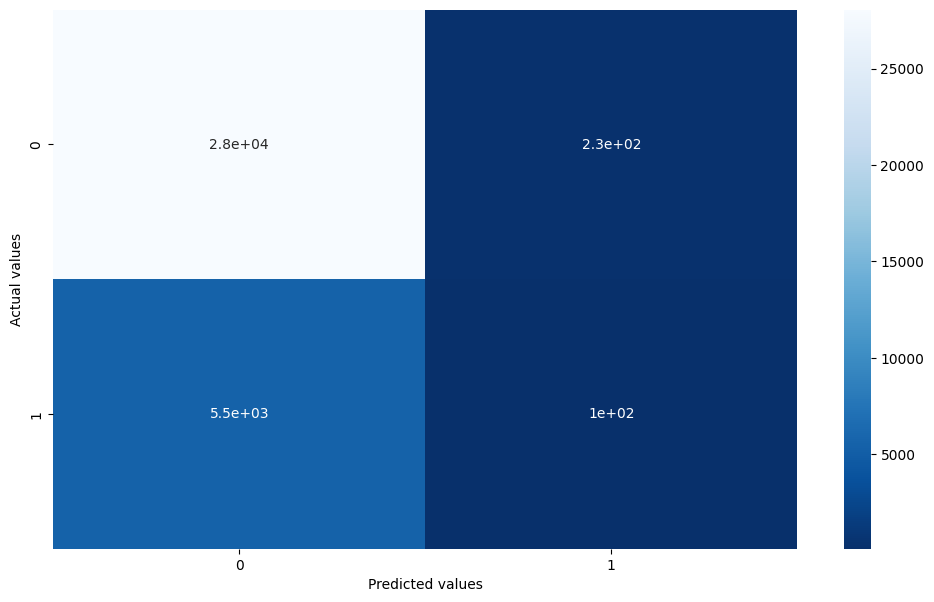

              precision    recall  f1-score   support

      Actual       0.84      0.99      0.91     28282
        Pred       0.30      0.02      0.03      5620

    accuracy                           0.83     33902
   macro avg       0.57      0.50      0.47     33902
weighted avg       0.75      0.83      0.76     33902



In [11]:
#Logistic regression
LR = LogisticRegression(**best_lr_params)
LR.fit(X_train, y_train)
display_metrics(LR, X_test, y_test)
with open("./data/models/LR.pkl", "wb") as lr:
    pickle.dump(LR, lr)

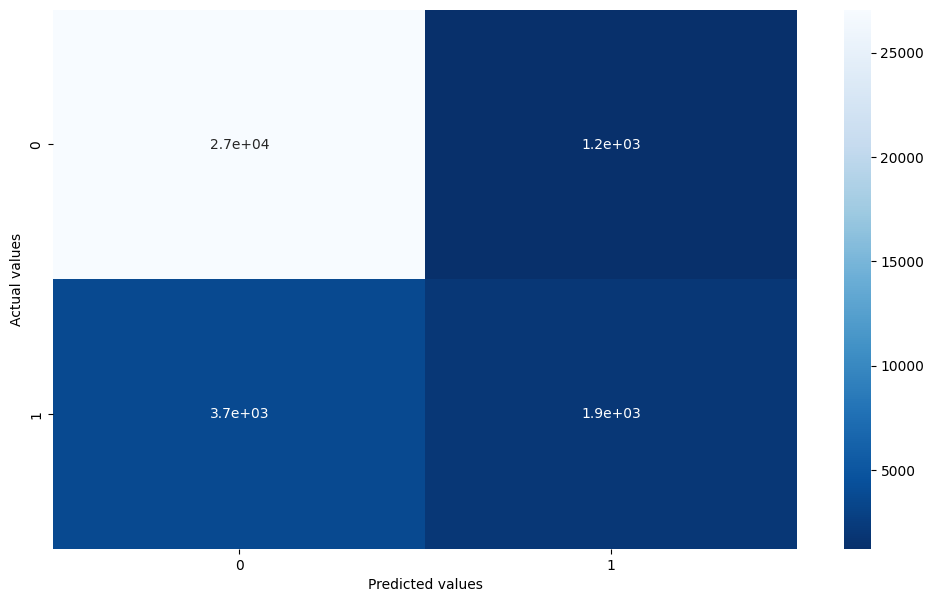

              precision    recall  f1-score   support

      Actual       0.88      0.96      0.92     28282
        Pred       0.61      0.34      0.44      5620

    accuracy                           0.86     33902
   macro avg       0.75      0.65      0.68     33902
weighted avg       0.84      0.86      0.84     33902



In [7]:
# RFC
rfc = RandomForestClassifier(**best_rfc_params)
rfc.fit(X_train, y_train)
display_metrics(rfc, X_test, y_test)
with open("./data/models/RFC.pkl", "wb") as RFC:
    pickle.dump(rfc, RFC)

/home/vlad/miniconda3/envs/yolov8/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


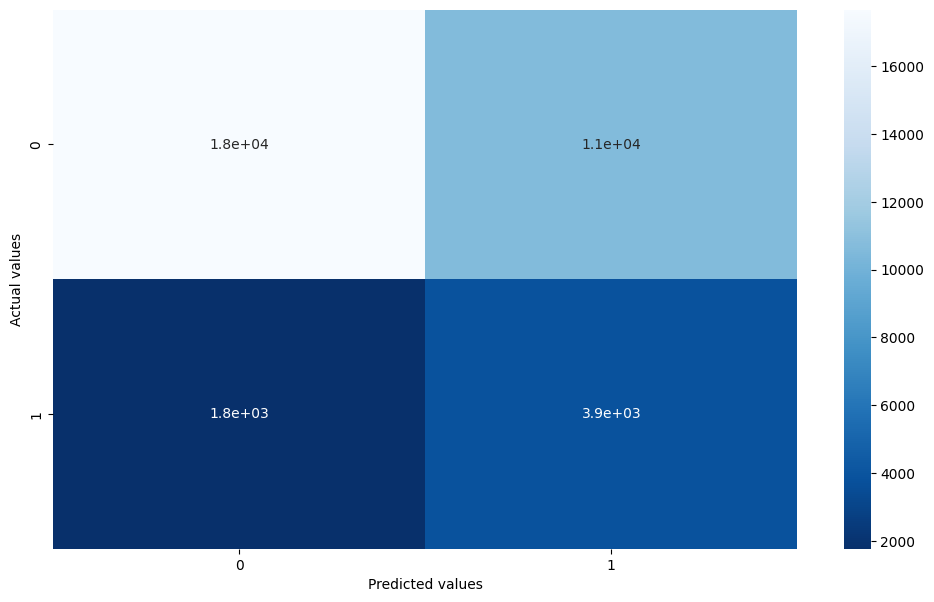

              precision    recall  f1-score   support

      Actual       0.91      0.62      0.74     28282
        Pred       0.27      0.69      0.38      5620

    accuracy                           0.63     33902
   macro avg       0.59      0.66      0.56     33902
weighted avg       0.80      0.63      0.68     33902



In [6]:
# Multi-layer Perceptron
mlp = MLPClassifier(**best_mlp_params)
mlp.fit(X_train, y_train)
display_metrics(mlp, X_test, y_test)
with open("./data/models/MLP.pkl", "wb") as MLP:
    pickle.dump(mlp, MLP)

## Find top features <a class="anchor" id="top_features"></a>

### RFC <a class="anchor" id="rfc_top"></a>

In [13]:
feature_coefs = rfc.feature_importances_[:len(feature_names)]

In [14]:
features = list(zip(feature_names, feature_coefs))
features

[('day_tempmax', 0.026317423520251522),
 ('day_tempmin', 0.028029070148911813),
 ('day_temp', 0.027705185029385446),
 ('day_dew', 0.02767471471992014),
 ('day_humidity', 0.027394275862224034),
 ('day_precip', 0.015118892972218521),
 ('day_precipcover', 0.01188040025947426),
 ('day_solarradiation', 0.02800913603238065),
 ('day_solarenergy', 0.02844396822752637),
 ('day_uvindex', 0.013540794918684599),
 ('day_moonphase', 0.0003658787777938773),
 ('hour_temp', 0.06619002654565202),
 ('hour_humidity', 0.06451784391119665),
 ('hour_dew', 0.060393124525924304),
 ('hour_precip', 0.005704119029984201),
 ('hour_precipprob', 0.0035246508594411747),
 ('hour_snow', 0.0009211801185028727),
 ('hour_snowdepth', 0.008140355736880286),
 ('hour_windgust', 0.06282272116099324),
 ('hour_windspeed', 0.05511573383845158),
 ('hour_winddir', 0.06123918855147087),
 ('hour_pressure', 0.05390016107039704),
 ('hour_visibility', 0.022581348716743575),
 ('hour_cloudcover', 0.045285610930926805),
 ('hour_solarradiat

In [15]:
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)[:20]
sorted_features

[('hour_temp', 0.06619002654565202),
 ('hour_humidity', 0.06451784391119665),
 ('hour_windgust', 0.06282272116099324),
 ('hour_winddir', 0.06123918855147087),
 ('hour_dew', 0.060393124525924304),
 ('hour_solarradiation', 0.05520094634408526),
 ('hour_windspeed', 0.05511573383845158),
 ('hour_pressure', 0.05390016107039704),
 ('hour_cloudcover', 0.045285610930926805),
 ('hour_uvindex', 0.03519523671850946),
 ('day_solarenergy', 0.02844396822752637),
 ('day_tempmin', 0.028029070148911813),
 ('day_solarradiation', 0.02800913603238065),
 ('day_temp', 0.027705185029385446),
 ('day_dew', 0.02767471471992014),
 ('day_humidity', 0.027394275862224034),
 ('day_tempmax', 0.026317423520251522),
 ('region_id', 0.023536960700336545),
 ('hour_visibility', 0.022581348716743575),
 ('hour_conditions_id', 0.01720830743994136)]

In [16]:
feature_names = [x[0] for x in sorted_features]
feature_weights = [x[1] for x in sorted_features]


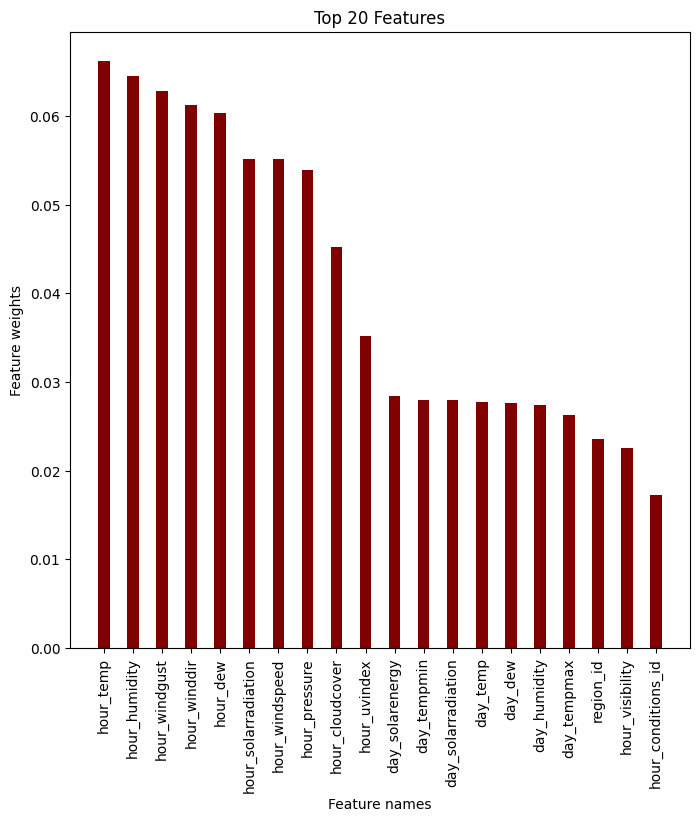

In [17]:
plt.figure(figsize=(8, 8))
plt.bar(feature_names, feature_weights, color ='maroon',
        width = 0.4)

plt.xlabel("Feature names")
plt.ylabel("Feature weights")
plt.title("Top 20 Features")
plt.xticks(rotation=90)
plt.show()

### LR <a class="anchor" id="lr_top"></a>

In [ ]:
r = permutation_importance(LR, X_test.toarray(), y_test, n_repeats=5, random_state=0)    

### MLP <a class="anchor" id="mlp_top"></a>

In [ ]:
r = permutation_importance(mlp, X_test.toarray(), y_test, n_repeats=5, random_state=0) 